In [1]:
import sys
from collections import defaultdict
from dataclasses import dataclass
from typing import List, Optional, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import phantom as ph

import cloudpickle

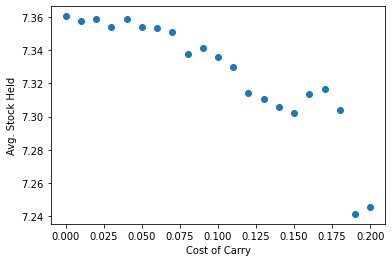

In [70]:
results = cloudpickle.load(open("../../../results1.pkl", "rb"))

data = defaultdict(list)

for result in results:
    data[result["cost_of_carry"]].append(result["mean_stock_held"])

x = list(data.keys())
y = list(map(np.mean, data.values()))

plt.scatter(x, y)
plt.xlabel("Cost of Carry")
plt.ylabel("Avg. Stock Held")
plt.show()

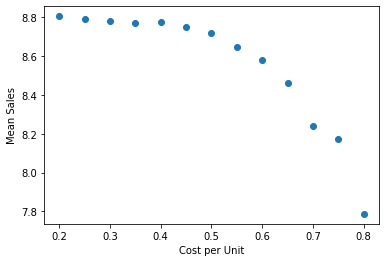

In [18]:
results = cloudpickle.load(open("../../../results2.pkl", "rb"))

data = defaultdict(list)

for result in results:
    data[result["cost_per_unit"]].append(result["mean_sales"])

x = list(data.keys())
y = list(map(np.mean, data.values()))

plt.scatter(x, y)
plt.xlabel("Cost per Unit")
plt.ylabel("Mean Sales")
plt.show()

In [20]:
# Price = 1.0, Cost per Unit = 0.5, Cost of carry = 0.2

results = cloudpickle.load(open("../../../results3.pkl", "rb"))

for metric in results[0].keys():
    print(metric, np.mean([m[metric] for m in results]))

stock/SHOP1 7.261340000000001
sales/SHOP1 8.7314
price/SHOP1 1.01
missed_sales/SHOP1 1.26654
delivered_stock/SHOP1 8.87852


In [29]:
result = cloudpickle.load(open("../../../results4.pkl", "rb"))[0]

for step in result.steps[:10]:
    if step.stage == "sales_step":
        continue

    obs = step.observations['SHOP1']
    acts = step.actions['SHOP1']

    print(f"Day {step.i // 2}:")
    print(f"  Shop Observations:\tStock: {obs['stock']}\t\tSales: {obs['previous_sales']}")
    print(f"  Shop Actions:\t\tRestock Qty: {acts['restock']}")

Day 0:
  Shop Observations:	Stock: 0		Sales: 0
  Shop Actions:		Restock Qty: 14
Day 1:
  Shop Observations:	Stock: 4		Sales: 10
  Shop Actions:		Restock Qty: 6
Day 2:
  Shop Observations:	Stock: 3		Sales: 7
  Shop Actions:		Restock Qty: 6
Day 3:
  Shop Observations:	Stock: 2		Sales: 7
  Shop Actions:		Restock Qty: 6
Day 4:
  Shop Observations:	Stock: 0		Sales: 8
  Shop Actions:		Restock Qty: 6


In [32]:
from ray.rllib.algorithms.registry import get_trainer_class
from ray.tune.registry import register_env

from supply_chain import SupplyChainEnv

directory = "/home/ubuntu/ray_results/PPO/PPO_SupplyChainEnv_d97bd_00000_0_2022-09-02_08-54-27/"

with open(directory + "params.pkl", "rb") as params_file:
    config = cloudpickle.load(params_file)

register_env(
    "SupplyChainEnv", lambda config: ph.utils.rllib.wrapper.RLlibEnvWrapper(SupplyChainEnv(**config))
)

trainer = get_trainer_class("PPO")(env="SupplyChainEnv", config=config)
trainer.restore(directory + "checkpoint_005700")

2022-09-02 13:58:59,871	INFO trainable.py:668 -- Restored on 10.0.8.222 from checkpoint: /home/ubuntu/ray_results/PPO/PPO_SupplyChainEnv_d97bd_00000_0_2022-09-02_08-54-27/checkpoint_005700
2022-09-02 13:58:59,873	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 5700, '_timesteps_total': None, '_time_total': 3190.3455832004547, '_episodes_total': 359100}


In [60]:
stocks = np.arange(0, 100)
sales = np.arange(0, 25)

restocks = np.ndarray((len(stocks), len(sales)))

for s1 in stocks:
    for s2 in sales:
        obs = {
            "type": {
                "sale_price": np.array([1.0]),
                "cost_of_carry": np.array([0.2]),
                "cost_per_unit": np.array([0.5]),
            },
            "stock": s1,
            "previous_sales": s2, 
        }

        action = trainer.compute_single_action(
            obs, policy_id="shop_policy", explore=False
        )

        restocks[s1, s2] = action["restock"]

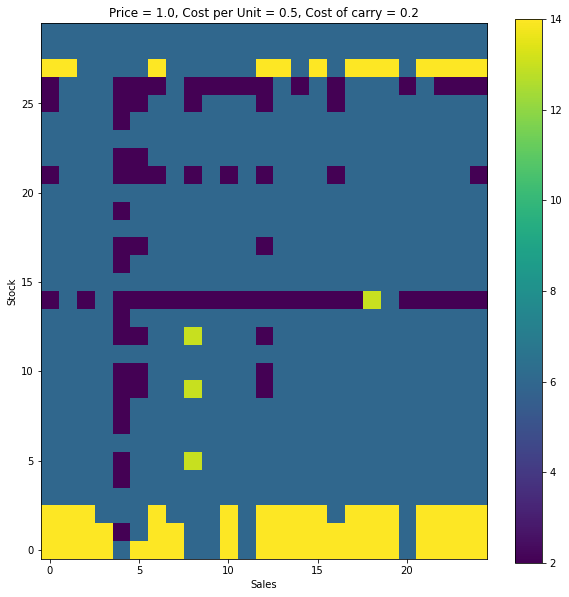

In [68]:
plt.figure(figsize=(10,10))
plt.title("Price = 1.0, Cost per Unit = 0.5, Cost of carry = 0.2")
plt.imshow(restocks[:30,])
plt.colorbar()
plt.xlabel("Sales")
plt.ylabel("Stock")
plt.gca().invert_yaxis()
plt.show()